# 0. 기존 DB자료 "Tab" → "," 변환

In [ ]:
# import pandas as pd

# df = pd.read_csv("ygs.csv", sep="\t", dtype=str, encoding="utf-8")
# df.to_csv("ygs2.csv", index=False, encoding="utf-8-sig")


# 1. 설정, 유틸 함수들

In [ ]:
# ===== 셀 1: 설정 + 유틸 =====
import os, json, math
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import pandas as pd

# ▼ CSV 파일이 있는 폴더와 파일명(원하면 수정)
ROOT = "."
FILES = [("ygs.csv", "YGS"), ("kum.csv", "KUM"), ("hws.csv", "HWS"), ("icn.csv", "ICN")]

# ▼ 출력 폴더
OUTDIR = Path("preprocessed")
OUTDIR.mkdir(parents=True, exist_ok=True)

# --- CSV 읽기(자동 구분자 감지 + 컬럼명 정규화: 소문자/특수문자→_) ---
def sniff_read_csv(path: str) -> Optional[pd.DataFrame]:
    if not os.path.exists(path):
        print(f"[INFO] 파일 없음: {path}")
        return None
    try:
        df = pd.read_csv(path, sep=None, engine="python")
        df.columns = (
            df.columns
            .str.strip()
            .str.lower()
            .str.replace(r"[^0-9a-zA-Z_]+", "_", regex=True)
        )
        return df
    except Exception as e:
        print(f"[ERROR] 읽기 실패 {path}: {e}")
        return None

# --- 데이터프레임 요약 출력 ---
def print_df_summary(name: str, df: pd.DataFrame, head_rows: int = 3) -> None:
    print(f"\n=== {name} | shape={df.shape} ===")
    print("Columns:", list(df.columns))
    print("Sample rows:")
    print(df.head(head_rows).to_string(index=False))

# --- 필수 컬럼 표준화(정확한 이름으로 강제) ---
#   주신 실제 컬럼 목록에 맞춰 '그대로' 매핑합니다.
#   - epc_code        ← 'epc_code'
#   - event_time      ← 'event_time'
#   - event_type      ← 'event_type'
#   - location_id     ← 'location_id'  (이름 유지; category로 사용)
REQUIRED = ["epc_code", "event_time", "event_type", "location_id"]

def standardize_required(df: pd.DataFrame) -> pd.DataFrame:
    # 이미 소문자/언더스코어 처리된 상태라는 가정하에, 필수 컬럼 확인
    missing = [c for c in REQUIRED if c not in df.columns]
    if missing:
        raise KeyError(f"필수 컬럼이 없습니다: {missing}\n"
                    f"현재 컬럼: {list(df.columns)}")
    # 불필요한 공백/형 변환 등은 아래 단계에서 처리
    return df

# --- 시간 파싱 + 시계열 피처(Δt, 시간대 sin/cos) ---
def ensure_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", utc=False)

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    if not {"epc_code", "event_time"}.issubset(df.columns):
        raise KeyError("시간 피처 생성을 위해 'epc_code'와 'event_time'이 필요합니다.")
    out = df.copy()
    out["event_time"] = ensure_dt(out["event_time"])
    # EPC별 시간 정렬
    out.sort_values(["epc_code", "event_time"], inplace=True, kind="stable")
    # Δt(초) — 시퀀스 시작은 0
    out["delta_t_sec"] = out.groupby("epc_code")["event_time"].diff().dt.total_seconds().fillna(0.0)
    # 시간대(0~23) → sin/cos
    hours = out["event_time"].dt.hour.astype(float)
    out["hour_sin"] = (2 * math.pi * hours / 24.0).apply(math.sin)
    out["hour_cos"] = (2 * math.pi * hours / 24.0).apply(math.cos)
    return out

# --- 간단 어휘집 생성기 ---
def build_vocab(series: pd.Series, name: str, min_freq: int = 1) -> Dict:
    """
    - 예약 토큰: <PAD>=0, <UNK>=1
    - 정렬: 빈도 내림차순 → (동률 시) 토큰 문자열 오름차순
    - location_id는 숫자여도 '코드'이므로 문자열로 변환 후 카테고리로 취급합니다.
    """
    s = series.astype(str)
    counts = s.value_counts(dropna=False)
    counts = counts[counts >= min_freq]
    items = sorted(counts.items(), key=lambda kv: (-int(kv[1]), str(kv[0])))
    id2token = ["<PAD>", "<UNK>"] + [str(k) for k, _ in items]
    return {
        "name": name,
        "reserved": ["<PAD>", "<UNK>"],
        "id2token": id2token,
        "counts": {str(k): int(v) for k, v in counts.items()},
    }

# --- 어휘집을 이용해 ID 인코딩 ---
def encode_with_vocab(series: pd.Series, vocab: Dict, colname: str) -> pd.Series:
    token2id = {tok: i for i, tok in enumerate(vocab["id2token"])}
    unk_id = vocab["reserved"].index("<UNK>") if "<UNK>" in vocab["reserved"] else 1
    return series.astype(str).map(lambda x: token2id.get(x, unk_id)).astype("int32")

# --- 저장 도우미(Parquet 우선, 실패 시 CSV 폴백) ---
def save_table(df: pd.DataFrame, path_parquet: Path, path_csv: Optional[Path] = None):
    try:
        df.to_parquet(path_parquet, index=False)
        print(f"[OK] 저장(parquet): {path_parquet} (shape={df.shape})")
    except Exception as e:
        if path_csv is None:
            path_csv = path_parquet.with_suffix(".csv")
        df.to_csv(path_csv, index=False)
        print(f"[WARN] parquet 저장 실패({e}) → CSV로 저장: {path_csv} (shape={df.shape})")


# 2. CSV 읽기 & 요약

In [ ]:
# ===== 셀 2: CSV 읽기 & 요약 =====
dfs = []
for fname, factory in FILES:
    path = os.path.join(ROOT, fname)
    df = sniff_read_csv(path)
    if df is None:
        continue
    print_df_summary(f"{fname} ({factory})", df)
    # factory가 데이터에 별도 컬럼으로 있을 수도 있지만, 파일별 라벨을 임시로 붙여둡니다.
    df["__factory_label__"] = factory
    dfs.append(df)

if not dfs:
    raise SystemExit("[STOP] CSV를 하나도 찾지 못했습니다. 파일 경로/이름을 확인하세요.")



=== ygs.csv (YGS) | shape=(132200, 18) ===
Columns: ['_scan_location', 'location_id', 'hub_type', 'business_step', 'event_type', 'operator_id', 'device_id', 'epc_code', 'epc_header', 'epc_company', 'epc_product', 'epc_lot', 'epc_manufacture', 'epc_serial', 'product_name', 'event_time', 'manufacture_date', 'expiry_date']
Sample rows:
_scan_location  location_id    hub_type business_step  event_type  operator_id  device_id                                      epc_code  epc_header  epc_company  epc_product  epc_lot  epc_manufacture  epc_serial product_name          event_time    manufacture_date  expiry_date
          양산공장            3 YGS_Factory       Factory Aggregation            3          3 001.8805843.2932031.100001.20250701.000000001           1      8805843      2932031   100001         20250701           1    Product 1 2025-07-01 10:23:39 2025-07-01 10:23:39     20251231
          양산공장            3 YGS_Factory       Factory Aggregation            3          3 001.8809437.120319

# 3. 병합 → 필수 컬럼 표준화 → 저장

In [ ]:
# ===== 셀 3: 병합/표준화/저장 =====
merged = pd.concat(dfs, ignore_index=True)
print(f"\n[INFO] 병합 shape: {merged.shape}")

# 필수 컬럼 확인/고정(정확한 이름 사용)
std = standardize_required(merged)

# factory 최종화: 원본에 'factory'가 없다면, 임시 라벨 사용
if "factory" not in std.columns:
    std["factory"] = std.pop("__factory_label__")
else:
    std.drop(columns=["__factory_label__"], errors="ignore", inplace=True)

# [수정 제안] Parquet 저장을 위해 데이터 타입을 명시적으로 변환
# 문제가 될 만한 object 타입 컬럼을 문자열(str)로 바꿔줍니다.
for col in std.select_dtypes(include=['object']).columns:
    print(f"[DEBUG] Converting column '{col}' to string type for Parquet compatibility.")
    std[col] = std[col].astype(str)

# 저장
save_table(std, OUTDIR / "combined.parquet")



[INFO] 병합 shape: (920000, 19)
[DEBUG] Converting column '_scan_location' to string type for Parquet compatibility.
[DEBUG] Converting column 'hub_type' to string type for Parquet compatibility.
[DEBUG] Converting column 'business_step' to string type for Parquet compatibility.
[DEBUG] Converting column 'event_type' to string type for Parquet compatibility.
[DEBUG] Converting column 'epc_code' to string type for Parquet compatibility.
[DEBUG] Converting column 'product_name' to string type for Parquet compatibility.
[DEBUG] Converting column 'event_time' to string type for Parquet compatibility.
[DEBUG] Converting column 'manufacture_date' to string type for Parquet compatibility.
[DEBUG] Converting column 'factory' to string type for Parquet compatibility.
[OK] 저장(parquet): preprocessed\combined.parquet (shape=(920000, 19))


# 4. 시간 피처(Δt, hour sin/cos) 생성 → 저장

In [ ]:
# ===== 셀 4: 시간 피처 생성/저장 =====
std_time = add_time_features(std)

# --- [수정] Parquet 저장을 위한 임시 데이터프레임 생성 ---
# 원본 std_time의 타입을 바꾸지 않고, 저장을 위한 복사본을 만듭니다.
df_to_save = std_time.copy()

# datetime 타입은 종종 Parquet 변환 시 문제를 일으키므로,
# 가장 안전한 ISO 8601 표준 문자열 포맷으로 변환하여 저장합니다.
df_to_save["event_time"] = df_to_save["event_time"].astype(str)
# --------------------------------------------------------

save_table(std_time, OUTDIR / "combined_with_time.parquet")


[OK] 저장(parquet): preprocessed\combined_with_time.parquet (shape=(920000, 22))


# 5. 어휘집 생성(JSON) + ID 인코딩 컬럼 추가 → 저장

In [ ]:
# ===== 셀 5: vocab 생성 + ID 인코딩 =====

# 1) event_type 어휘집
vocab_event = build_vocab(std_time["event_type"], name="event_type", min_freq=1)
with open(OUTDIR / "event_type.vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab_event, f, ensure_ascii=False, indent=2)
print(f"[OK] 어휘집 저장: {OUTDIR / 'event_type.vocab.json'} (size={len(vocab_event['id2token'])})")

# 2) location_id 어휘집 (숫자지만 '코드'이므로 카테고리 취급)
vocab_loc = build_vocab(std_time["location_id"], name="location_id", min_freq=1)
with open(OUTDIR / "location_id.vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab_loc, f, ensure_ascii=False, indent=2)
print(f"[OK] 어휘집 저장: {OUTDIR / 'location_id.vocab.json'} (size={len(vocab_loc['id2token'])})")

# 3) ID 인코딩 컬럼 추가
encoded = std_time.copy()
encoded["event_type_id"]  = encode_with_vocab(encoded["event_type"],  vocab_event, "event_type")
encoded["location_id_id"] = encode_with_vocab(encoded["location_id"], vocab_loc,   "location_id")

# 저장
save_table(encoded, OUTDIR / "combined_encoded.parquet")


[OK] 어휘집 저장: preprocessed\event_type.vocab.json (size=12)
[OK] 어휘집 저장: preprocessed\location_id.vocab.json (size=60)
[OK] 저장(parquet): preprocessed\combined_encoded.parquet (shape=(920000, 24))


# 6. 모델 학습을 위한 준비 - 데이터 분할 및 스케일링

In [ ]:
# ===== 셀 6: 데이터 분할, 스케일링, 최종 저장 =====
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib # 스케일러 저장을 위해 사용

# 1. 셀 5에서 최종적으로 생성된 데이터를 불러옵니다.
print("[INFO] 스케일링을 위해 인코딩된 데이터를 불러옵니다.")
try:
    final_df = pd.read_parquet(OUTDIR / "combined_encoded.parquet")
except FileNotFoundError:
    # Parquet 저장 실패 시 생성된 CSV를 대신 읽음
    final_df = pd.read_csv(OUTDIR / "combined_encoded.csv")

# 2. 데이터를 학습(Train)과 테스트(Test) 세트로 분할합니다.
#    (시계열 데이터이므로 epc_code 단위로 분할하거나, 시간순으로 분할하는 것이 더 좋습니다.)
#    여기서는 간단한 예시로 랜덤 분할을 사용합니다. epc_code를 기준으로 분할해야 합니다.
epc_codes = final_df["epc_code"].unique()

# 2. 이 식별자 자체를 80:20으로 랜덤하게 나눕니다.
train_epcs, test_epcs = train_test_split(epc_codes, test_size=0.2, random_state=42)

train_df = final_df[final_df["epc_code"].isin(train_epcs)].copy()
test_df = final_df[final_df["epc_code"].isin(test_epcs)].copy()

print(f"[INFO] 데이터 분할 완료: Train={train_df.shape}, Test={test_df.shape}")

# 3. 스케일링 할 컬럼을 지정합니다.
cols_to_scale = ['delta_t_sec'] # 스케일 조정이 필요한 컬럼 목록

# 4. StandardScaler를 생성하고 '학습 데이터'에만 fit합니다.
scaler = StandardScaler()
print(f"[INFO] 학습 데이터의 '{cols_to_scale}' 컬럼에 스케일러를 학습(fit)합니다.")
# scaler.fit()은 2D 배열을 기대하므로, 대괄호를 두 번 사용합니다.
scaler.fit(train_df[cols_to_scale])

# 5. 학습된 스케일러로 Train, Test 데이터 모두를 transform합니다.
print("[INFO] 학습된 스케일러로 Train/Test 데이터를 변환(transform)합니다.")
train_df[cols_to_scale] = scaler.transform(train_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

# 6. 학습된 스케일러를 파일로 저장합니다. (어휘집 저장만큼 중요!)
scaler_path = OUTDIR / "delta_t_scaler.joblib"
joblib.dump(scaler, scaler_path)
print(f"[OK] 학습된 스케일러 저장 완료: {scaler_path}")

# 7. 스케일링까지 완료된 최종 데이터셋을 각각 저장합니다.
save_table(train_df, OUTDIR / "train_final.parquet")
save_table(test_df, OUTDIR / "test_final.parquet")

print("\n--- 스케일링 결과 확인 (Train Set) ---")
print(train_df[cols_to_scale].describe())

[INFO] 스케일링을 위해 인코딩된 데이터를 불러옵니다.
[INFO] 데이터 분할 완료: Train=(736188, 24), Test=(183812, 24)
[INFO] 학습 데이터의 '['delta_t_sec']' 컬럼에 스케일러를 학습(fit)합니다.
[INFO] 학습된 스케일러로 Train/Test 데이터를 변환(transform)합니다.
[OK] 학습된 스케일러 저장 완료: preprocessed\delta_t_scaler.joblib
[OK] 저장(parquet): preprocessed\train_final.parquet (shape=(736188, 24))
[OK] 저장(parquet): preprocessed\test_final.parquet (shape=(183812, 24))

--- 스케일링 결과 확인 (Train Set) ---
        delta_t_sec
count  7.361880e+05
mean  -1.482493e-17
std    1.000001e+00
min   -5.533837e-01
25%   -5.508160e-01
50%   -5.353657e-01
75%    6.948806e-02
max    3.022292e+00


# 7-1. Window Size 결정
- describe() 결과에서 25% ~ 50%의 데이터 길이가 45에 몰려 있다면, 윈도우 크기를 3으로 하는 것이 더 많은 데이터를 활용하는 방법

In [ ]:
# (셀 6에서 생성한) final_df가 로드되어 있다고 가정
sequence_lengths = final_df.groupby('epc_code').size()
print(sequence_lengths.describe())

# 시퀀스 길이가 5 미만인 데이터의 비율 확인
short_sequences_ratio1 = (sequence_lengths > 7).mean()
print(f"\n시퀀스 길이가 7 이상인 데이터의 비율: {short_sequences_ratio1:.2%}")
short_sequences_ratio2 = (sequence_lengths < 6).mean()
print(f"\n시퀀스 길이가 6 미만인 데이터의 비율: {short_sequences_ratio2:.2%}")
short_sequences_ratio3 = (sequence_lengths < 5).mean()
print(f"\n시퀀스 길이가 5 미만인 데이터의 비율: {short_sequences_ratio3:.2%}")
short_sequences_ratio4 = (sequence_lengths < 4).mean()
print(f"\n시퀀스 길이가 4 미만인 데이터의 비율: {short_sequences_ratio4:.2%}")
short_sequences_ratio5 = (sequence_lengths < 3).mean()
print(f"\n시퀀스 길이가 3 미만인 데이터의 비율: {short_sequences_ratio5:.2%}")


count    200000.000000
mean          4.600000
std           2.537722
min           2.000000
25%           2.000000
50%           4.000000
75%           6.500000
max          10.000000
dtype: float64

시퀀스 길이가 7 이상인 데이터의 비율: 25.00%

시퀀스 길이가 6 미만인 데이터의 비율: 65.00%

시퀀스 길이가 5 미만인 데이터의 비율: 65.00%

시퀀스 길이가 4 미만인 데이터의 비율: 35.00%

시퀀스 길이가 3 미만인 데이터의 비율: 35.00%


# 7. 슬라이딩 윈도우(Sliding Window)를 활용한 시계열 데이터 → 학습용 샘플로 만들기

### 코드에 대한 상세 설명

1.  **하이퍼파라미터 설정:**
    *   `WINDOW_SIZE`: 모델 성능에 큰 영향을 주는 중요한 파라미터입니다. 문제의 특성에 맞게 조절이 필요합니다. (예: 7로 설정하면, 과거 7개 이벤트를 보고 8번째 이벤트를 예측)
    *   `INPUT_FEATURES`: 모델의 입력으로 사용할, 수치로 변환된 컬럼들만 선택합니다.
    *   `TARGET_COLUMNS`: 모델이 맞춰야 할 정답입니다. `event_type_id` 외에 `location_id_id` 등을 추가하여 다중 예측 문제로 만들 수도 있습니다.

2.  **`create_sliding_window_dataset` 함수:**
    *   `df.groupby('epc_code')`: **가장 중요한 부분입니다.** 각 시퀀스(`epc_code`)별로 따로 슬라이딩 윈도우를 적용해야, 한 시퀀스의 끝과 다른 시퀀스의 시작이 섞이는 것을 방지할 수 있습니다.
    *   `tqdm`: 데이터가 많을 때 처리 시간 예측을 위해 진행 바(progress bar)를 보여주는 유용한 라이브러리입니다.
    *   `features = group[INPUT_FEATURES].values`: pandas 데이터프레임을 NumPy 배열로 변환합니다. 이게 계산 속도가 훨씬 빠릅니다.
    *   `for i in range(...)`: 루프를 돌면서 윈도우를 한 칸씩( `step_size` 만큼) 옆으로 이동시킵니다.
    *   `X_data.append(...)`, `y_data.append(...)`: 생성된 샘플들을 파이썬 리스트에 차곡차곡 쌓습니다.
    *   `np.array()`: 모든 처리가 끝난 후, 리스트를 최종적으로 NumPy 배열로 변환합니다.

3.  **저장 (`np.savez_compressed`):**
    *   생성된 `X`와 `y` 배열을 하나의 압축 파일(`.npz`)로 저장합니다.
    *   나중에 모델 학습 코드에서는 `data = np.load('train_dataset.npz')`, `X_train = data['X']`, `y_train = data['y']` 와 같이 쉽게 불러올 수 있습니다.

이제 이 코드를 실행하시면 `train_dataset.npz`와 `test_dataset.npz` 파일이 생성되며, 이 파일들이 바로 딥러닝 모델을 학습시킬 준비가 완료된 최종 입력 데이터입니다.

In [ ]:
# # 첫 번째 실행: 
# # WINDOW_SIZE = 2로 설정하고 실행하여 
# # train_dataset_ws2.npz, test_dataset_ws2.npz 파일을 생성합니다.

# # ===== 셀 7: 슬라이딩 윈도우로 학습 데이터셋 생성 =====
# import numpy as np
# import pandas as pd
# from tqdm import tqdm # 진행 상황을 시각적으로 보여주는 라이브러리
# import os

# # --- 1. 하이퍼파라미터 설정 ---
# # 모델이 몇 개의 과거 이벤트를 보고 다음을 예측할지 결정합니다.
# WINDOW_SIZE = 2  # 예: 과거 7개 이벤트를 보고
# STEP_SIZE = 1    # 윈도우를 한 칸씩 이동

# # 모델의 입력으로 사용할 피처(컬럼) 목록을 정의합니다.
# # 원본 ID, 시간 정보 등은 보통 제외하고, 인코딩/스케일링된 값만 사용합니다.
# INPUT_FEATURES = [
#     'event_type_id',
#     'location_id_id',
#     'delta_t_sec',  # 스케일링 완료된 시간 차이
#     'hour_sin',     # 주기성 피처
#     'hour_cos'      # 주기성 피처
# ]

# # 모델이 예측해야 할 정답(Target) 컬럼을 정의합니다.
# # 가장 일반적인 목표는 '다음 이벤트 타입'을 예측하는 것입니다.
# TARGET_COLUMNS = ['event_type_id']

# # --- 2. 데이터셋 생성을 위한 함수 정의 ---
# def create_sliding_window_dataset(df: pd.DataFrame, window_size: int, step_size: int):
#     X_data, y_data = [], []
    
#     # tqdm을 사용해 epc_code 그룹별로 루프를 실행하며 진행 상황을 표시합니다.
#     grouped = df.groupby('epc_code')
#     for _, group in tqdm(grouped, desc="Processing sequences"):
#         # 각 시퀀스를 feature와 target으로 분리합니다.
#         features = group[INPUT_FEATURES].values
#         targets = group[TARGET_COLUMNS].values
        
#         # 시퀀스 길이가 윈도우 크기보다 짧으면 샘플을 만들 수 없으므로 건너뜁니다.
#         # (예: 윈도우가 7이면, 최소 8개의 이벤트가 있어야 X, y 쌍 1개를 만듦)
#         if len(group) < window_size + 1:
#             continue
            
#         # 슬라이딩 윈도우를 적용하여 X, y 쌍을 생성합니다.
#         for i in range(0, len(group) - window_size, step_size):
#             window_end = i + window_size
            
#             # 입력 시퀀스 (X)
#             input_window = features[i:window_end]
#             X_data.append(input_window)
            
#             # 정답 (y) - 윈도우 바로 다음 이벤트
#             target_event = targets[window_end]
#             y_data.append(target_event)
            
#     # 파이썬 리스트를 딥러닝에 적합한 NumPy 배열로 변환합니다.
#     return np.array(X_data), np.array(y_data)

# # --- 3. Train/Test 데이터셋 생성 및 저장 ---
# def process_and_save_dataset(name: str):
#     print(f"\n--- {name.upper()} 데이터셋 생성 시작 ---")
#     parquet_path = OUTDIR / f"{name}_final.parquet"
#     csv_path = OUTDIR / f"{name}_final.csv"

#     # parquet 파일이 있으면 읽고, 없으면 csv 파일을 읽습니다.
#     if os.path.exists(parquet_path):
#         df = pd.read_parquet(parquet_path)
#     else:
#         df = pd.read_csv(csv_path, parse_dates=['event_time'])

#     # 슬라이딩 윈도우 함수를 호출합니다.
#     X, y = create_sliding_window_dataset(df, WINDOW_SIZE, STEP_SIZE)

#     # 생성된 데이터의 shape(모양)을 출력합니다.
#     # X shape: (총 샘플 수, 윈도우 크기, 피처 개수)
#     # y shape: (총 샘플 수, 타겟 개수)
#     print(f"생성된 {name} 데이터 shape: X={X.shape}, y={y.shape}")

#     # NumPy 포맷으로 최종 데이터를 저장합니다.
#     # .npz는 여러 배열을 한 파일에 압축 저장하는 효율적인 포맷입니다.
#     np.savez_compressed(
#         OUTDIR / f"{name}_dataset_ws2.npz",
#         X=X,
#         y=y
#     )
#     print(f"[OK] {name.upper()} 데이터셋 저장 완료: {OUTDIR / f'{name}_dataset_ws2.npz'}")

# process_and_save_dataset("train")
# process_and_save_dataset("test")

# print("\n모든 작업이 완료되었습니다. 이제 .npz 파일을 이용해 모델 학습을 시작할 수 있습니다.")

In [ ]:
# 두 번째 실행: WINDOW_SIZE = 3으로 설정하고 실행하여 
# train_dataset_ws3.npz, test_dataset_ws3.npz 파일을 생성합니다.


# ===== 셀 7: 슬라이딩 윈도우로 학습 데이터셋 생성 =====
import numpy as np
import pandas as pd
from tqdm import tqdm # 진행 상황을 시각적으로 보여주는 라이브러리
import os

# --- 1. 하이퍼파라미터 설정 ---
# 모델이 몇 개의 과거 이벤트를 보고 다음을 예측할지 결정합니다.
WINDOW_SIZE = 3  # 예: 과거 7개 이벤트를 보고
STEP_SIZE = 1    # 윈도우를 한 칸씩 이동

# 모델의 입력으로 사용할 피처(컬럼) 목록을 정의합니다.
# 원본 ID, 시간 정보 등은 보통 제외하고, 인코딩/스케일링된 값만 사용합니다.
INPUT_FEATURES = [
    'event_type_id',
    'location_id_id',
    'delta_t_sec',  # 스케일링 완료된 시간 차이
    'hour_sin',     # 주기성 피처
    'hour_cos'      # 주기성 피처
]

# 모델이 예측해야 할 정답(Target) 컬럼을 정의합니다.
# 가장 일반적인 목표는 '다음 이벤트 타입'을 예측하는 것입니다.
TARGET_COLUMNS = ['event_type_id']

# --- 2. 데이터셋 생성을 위한 함수 정의 ---
def create_sliding_window_dataset(df: pd.DataFrame, window_size: int, step_size: int):
    X_data, y_data = [], []
    
    # tqdm을 사용해 epc_code 그룹별로 루프를 실행하며 진행 상황을 표시합니다.
    grouped = df.groupby('epc_code')
    for _, group in tqdm(grouped, desc="Processing sequences"):
        # 각 시퀀스를 feature와 target으로 분리합니다.
        features = group[INPUT_FEATURES].values
        targets = group[TARGET_COLUMNS].values
        
        # 시퀀스 길이가 윈도우 크기보다 짧으면 샘플을 만들 수 없으므로 건너뜁니다.
        # (예: 윈도우가 7이면, 최소 8개의 이벤트가 있어야 X, y 쌍 1개를 만듦)
        if len(group) < window_size + 1:
            continue
            
        # 슬라이딩 윈도우를 적용하여 X, y 쌍을 생성합니다.
        for i in range(0, len(group) - window_size, step_size):
            window_end = i + window_size
            
            # 입력 시퀀스 (X)
            input_window = features[i:window_end]
            X_data.append(input_window)
            
            # 정답 (y) - 윈도우 바로 다음 이벤트
            target_event = targets[window_end]
            y_data.append(target_event)
            
    # 파이썬 리스트를 딥러닝에 적합한 NumPy 배열로 변환합니다.
    return np.array(X_data), np.array(y_data)

# --- 3. Train/Test 데이터셋 생성 및 저장 ---
def process_and_save_dataset(name: str):
    print(f"\n--- {name.upper()} 데이터셋 생성 시작 ---")
    parquet_path = OUTDIR / f"{name}_final.parquet"
    csv_path = OUTDIR / f"{name}_final.csv"

    # parquet 파일이 있으면 읽고, 없으면 csv 파일을 읽습니다.
    if os.path.exists(parquet_path):
        df = pd.read_parquet(parquet_path)
    else:
        df = pd.read_csv(csv_path, parse_dates=['event_time'])

    # 슬라이딩 윈도우 함수를 호출합니다.
    X, y = create_sliding_window_dataset(df, WINDOW_SIZE, STEP_SIZE)

    # 생성된 데이터의 shape(모양)을 출력합니다.
    # X shape: (총 샘플 수, 윈도우 크기, 피처 개수)
    # y shape: (총 샘플 수, 타겟 개수)
    print(f"생성된 {name} 데이터 shape: X={X.shape}, y={y.shape}")

    # NumPy 포맷으로 최종 데이터를 저장합니다.
    # .npz는 여러 배열을 한 파일에 압축 저장하는 효율적인 포맷입니다.
    np.savez_compressed(
        OUTDIR / f"{name}_dataset_ws3.npz",
        X=X,
        y=y
    )
    print(f"[OK] {name.upper()} 데이터셋 저장 완료: {OUTDIR / f'{name}_dataset_ws3.npz'}")

process_and_save_dataset("train")
process_and_save_dataset("test")

print("\n모든 작업이 완료되었습니다. 이제 .npz 파일을 이용해 모델 학습을 시작할 수 있습니다.")


--- TRAIN 데이터셋 생성 시작 ---


Processing sequences: 100%|██████████| 160000/160000 [01:50<00:00, 1448.54it/s]


생성된 train 데이터 shape: X=(312154, 3, 5), y=(312154, 1)
[OK] TRAIN 데이터셋 저장 완료: preprocessed\train_dataset_ws3.npz

--- TEST 데이터셋 생성 시작 ---


Processing sequences: 100%|██████████| 40000/40000 [00:27<00:00, 1447.67it/s]


생성된 test 데이터 shape: X=(77846, 3, 5), y=(77846, 1)
[OK] TEST 데이터셋 저장 완료: preprocessed\test_dataset_ws3.npz

모든 작업이 완료되었습니다. 이제 .npz 파일을 이용해 모델 학습을 시작할 수 있습니다.


# 8. 앙상블 각각의 모델을 개별적으로 학습

In [ ]:
# ===== (신규 셀) 모델 학습 및 앙상블 =====
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score
from pathlib import Path  # Path 클래스를 사용하기 위해 import


# 이전 셀에서 정의했던 OUTDIR 변수를 다시 선언해줍니다.
# --- [수정 1] 변수 정의 ---
OUTDIR = Path("preprocessed")
# -----------------------------

# --- [수정 2] 어휘집 파일 로드 ---
print("[INFO] 어휘집 파일을 로드합니다...")
try:
    with open(OUTDIR / "event_type.vocab.json", "r", encoding="utf-8") as f:
        vocab_event = json.load(f)
    VOCAB_SIZE_EVENT = len(vocab_event['id2token'])
    print(f"[OK] event_type 어휘집 로드 완료. 클래스 개수: {VOCAB_SIZE_EVENT}")
except FileNotFoundError:
    print("[ERROR] event_type.vocab.json 파일을 찾을 수 없습니다! 셀 5를 먼저 실행하세요.")
    # 또는 기본값을 설정하거나 스크립트를 중단할 수 있습니다.
    VOCAB_SIZE_EVENT = 0 # 임시 값, 에러 방지
# -----------------------------------

# --- 1. 데이터 로드 ---
# 1-1. 윈도우 사이즈 2 데이터셋
# data_ws2 = np.load(OUTDIR / "train_dataset_ws2.npz")
# X_train_ws2, y_train_ws2 = data_ws2['X'], data_ws2['y']
# 1-2. 윈도우 사이즈 3 데이터셋
data_ws3 = np.load(OUTDIR / "train_dataset_ws3.npz")
X_train_ws3, y_train_ws3 = data_ws3['X'], data_ws3['y']

# (테스트 데이터도 동일하게 로드)
# test_data_ws2 = np.load(OUTDIR / "test_dataset_ws2.npz")
# X_test_ws2, y_test_ws2 = test_data_ws2['X'], test_data_ws2['y']
test_data_ws3 = np.load(OUTDIR / "test_dataset_ws3.npz")
X_test_ws3, y_test_ws3 = test_data_ws3['X'], test_data_ws3['y']


# --- 2. 모델 구조 정의 (재사용 가능하도록 함수로 만듦) ---
# 어휘집 크기(예측할 클래스 개수)를 가져옵니다.
# (실제로는 어휘집 json 파일을 로드해서 클래스 개수를 정확히 파악해야 합니다)
VOCAB_SIZE_EVENT = len(vocab_event['id2token'])

def build_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax') # 다중 분류를 위한 softmax
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- 3. 각 모델 개별 학습 ---
# print("\n--- 윈도우 사이즈 2 모델 학습 시작 ---")
# model_ws2 = build_model(input_shape=X_train_ws2.shape[1:], num_classes=VOCAB_SIZE_EVENT)
# model_ws2.fit(X_train_ws2, y_train_ws2, epochs=10, batch_size=256, validation_split=0.2)

print("\n--- 윈도우 사이즈 3 모델 학습 시작 ---")
model_ws3 = build_model(input_shape=X_train_ws3.shape[1:], num_classes=VOCAB_SIZE_EVENT)
model_ws3.fit(X_train_ws3, y_train_ws3, epochs=10, batch_size=256, validation_split=0.2)

[INFO] 어휘집 파일을 로드합니다...
[OK] event_type 어휘집 로드 완료. 클래스 개수: 12

--- 윈도우 사이즈 3 모델 학습 시작 ---
Epoch 1/10


c:\Users\user\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


976/976 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9417 - loss: 0.1997 - val_accuracy: 0.9814 - val_loss: 0.1618
Epoch 2/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9814 - val_loss: 0.1942
Epoch 3/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9814 - val_loss: 0.2155
Epoch 4/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 6.3559e-04 - val_accuracy: 0.9814 - val_loss: 0.2308
Epoch 5/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 2.8744e-04 - val_accuracy: 0.9814 - val_loss: 0.2464
Epoch 6/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 3.2506e-04 - val_accuracy: 0.9814 - val_loss: 0.2576
Epoch 7/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 1.1698e-04 - val_accuracy: 0.9814 - val_loss: 0.2714
Epoch 8/10
976/976 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 7.6301e-05 - val_acc

# 재학습 및 성능 시각화


--- [과적합 제어] 윈도우 사이즈 3 모델 학습 시작 ---
Epoch 1/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8898 - loss: 0.3838 - val_accuracy: 0.9811 - val_loss: 0.1554
Epoch 2/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9977 - loss: 0.0234 - val_accuracy: 0.9814 - val_loss: 0.1832
Epoch 3/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9991 - loss: 0.0092 - val_accuracy: 0.9814 - val_loss: 0.2141
Epoch 4/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9995 - loss: 0.0052 - val_accuracy: 0.9814 - val_loss: 0.2410
Epoch 5/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 0.9814 - val_loss: 0.2617
Epoch 6/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9814 - val_loss: 0.2798
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

--- 규제된 모델 학습 결과 시각화 ---


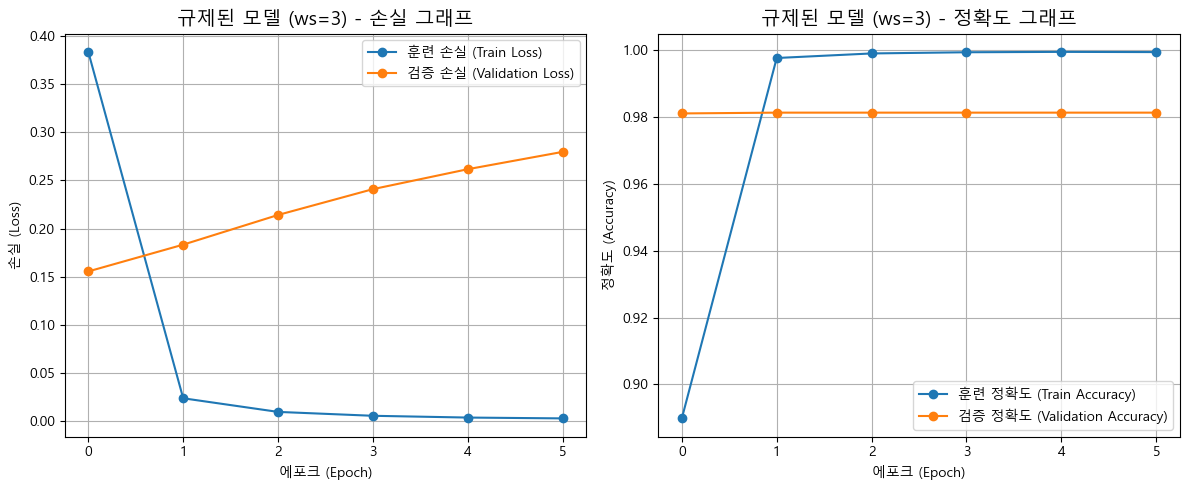

In [ ]:
# ===== (신규 셀) 과적합을 제어하는 모델 재학습 =====
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 이전에 로드한 변수들이 메모리에 있다고 가정 ---
# X_train_ws2, y_train_ws2, X_train_ws3, y_train_ws3
# VOCAB_SIZE_EVENT

# [해결책] 시각화 함수 정의를 여기에 포함시켜 줍니다.
# ----------------------------------------------------
def plot_history(history_data, model_name):
    plt.figure(figsize=(12, 5))
    
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 손실(Loss) 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history_data['loss'], label='훈련 손실 (Train Loss)', marker='o')
    plt.plot(history_data['val_loss'], label='검증 손실 (Validation Loss)', marker='o')
    plt.title(f'{model_name} - 손실 그래프', fontsize=14)
    plt.xlabel('에포크 (Epoch)')
    plt.ylabel('손실 (Loss)')
    plt.legend()
    plt.grid(True)
    
    # 정확도(Accuracy) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history_data['accuracy'], label='훈련 정확도 (Train Accuracy)', marker='o')
    plt.plot(history_data['val_accuracy'], label='검증 정확도 (Validation Accuracy)', marker='o')
    plt.title(f'{model_name} - 정확도 그래프', fontsize=14)
    plt.xlabel('에포크 (Epoch)')
    plt.ylabel('정확도 (Accuracy)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
# ----------------------------------------------------


# 1. 모델 복잡도 줄이기
def build_regularized_model(input_shape, num_classes):
    # 이전에 Input 경고가 있었으므로, Input 레이어를 명시적으로 추가해 줍니다.
    model = Sequential([
        tf.keras.Input(shape=input_shape), # 경고 메시지 해결을 위한 Input 레이어
        LSTM(32, return_sequences=False),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 3. 과적합 제어 모델로 재학습
# print("\n--- [과적합 제어] 윈도우 사이즈 2 모델 학습 시작 ---")
# model_ws2_reg = build_regularized_model(X_train_ws2.shape[1:], VOCAB_SIZE_EVENT)
# history_ws2_reg = model_ws2_reg.fit(X_train_ws2, y_train_ws2,
#                                 epochs=20,
#                                 batch_size=256,
#                                 validation_split=0.2,
#                                 callbacks=[early_stopping])

print("\n--- [과적합 제어] 윈도우 사이즈 3 모델 학습 시작 ---")
model_ws3_reg = build_regularized_model(X_train_ws3.shape[1:], VOCAB_SIZE_EVENT)
history_ws3_reg = model_ws3_reg.fit(X_train_ws3, y_train_ws3,
                                epochs=20,
                                batch_size=256,
                                validation_split=0.2,
                                callbacks=[early_stopping])

# 4. 재학습된 모델의 학습 과정 시각화
print("\n--- 규제된 모델 학습 결과 시각화 ---")
# 이제 plot_history 함수가 정의되어 있으므로 에러가 발생하지 않습니다.
# plot_history(history_ws2_reg.history, "규제된 모델 (ws=2)")
plot_history(history_ws3_reg.history, "규제된 모델 (ws=3)")

# 성능 테스트

In [ ]:
# # ===== (신규 셀) 규제된 모델의 최종 성능 평가 및 앙상블 =====
# import numpy as np
# from sklearn.metrics import accuracy_score, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 1. 테스트 데이터에 대한 예측 수행 ---
# # 두 데이터셋의 샘플 수가 다를 수 있으므로, 더 작은 쪽을 기준으로 삼습니다.
# # 이는 간단한 비교를 위함이며, 실제로는 시퀀스 ID를 매칭하는 것이 더 정확합니다.
# # num_samples = min(len(X_test_ws2), len(X_test_ws3))
# num_samples = len(X_test_ws3)
# print(f"[INFO] 앙상블 및 비교를 위해 {num_samples}개의 테스트 샘플을 사용합니다.")

# # 예측에 사용할 공통 테스트 데이터셋 슬라이싱
# # X_test_common_ws2 = X_test_ws2[:num_samples]
# X_test_common_ws3 = X_test_ws3[:num_samples]

# # 두 데이터셋 중 어느 쪽을 기준으로 삼았는지에 따라 정답 라벨(y)을 맞춰줍니다.
# # if len(X_test_ws2) == num_samples:
# #     y_test_common = y_test_ws2
# # else:
# y_test_common = y_test_ws3[:num_samples]


# # 각 규제된 모델로 예측 확률을 구합니다.
# print("[INFO] 각 모델로 예측을 수행합니다...")
# # pred_prob_ws2_reg = model_ws2_reg.predict(X_test_common_ws2)
# pred_prob_ws3_reg = model_ws3_reg.predict(X_test_common_ws3)

# # 예측 확률로부터 최종 클래스(가장 확률이 높은 인덱스)를 구합니다.
# # pred_class_ws2_reg = np.argmax(pred_prob_ws2_reg, axis=1)
# pred_class_ws3_reg = np.argmax(pred_prob_ws3_reg, axis=1)


# # --- [수정] classification_report를 위한 라벨 정보 생성 ---
# # 1. 실제 클래스 이름 목록 (기존과 동일)
# target_names = vocab_event['id2token'][2:]  # 총 10개

# # 2. 클래스 인덱스 목록 (2부터 11까지)
# #    VOCAB_SIZE_EVENT는 총 12 (<PAD>,<UNK> 포함)
# labels_to_report = list(range(2, VOCAB_SIZE_EVENT)) # [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# # -------------------------------------------------------------


# # --- 2. 개별 모델 성능 상세 평가 ---
# # 어휘집의 id-토큰 매핑을 사용하여 리포트에 실제 이벤트 타입을 표시합니다.
# target_names = vocab_event['id2token'][2:] # <PAD>, <UNK> 제외

# # print("\n\n--- 모델 (ws=2, 규제됨) 성능 리포트 ---")
# # acc_ws2_reg = accuracy_score(y_test_common, pred_class_ws2_reg)
# # print(f"정확도 (Accuracy): {acc_ws2_reg:.4f}")
# # print(classification_report(y_test_common, pred_class_ws2_reg,
# #                             labels=labels_to_report,     # ★ 이 파라미터 추가!
# #                             target_names=target_names,   # 이름표
# #                             zero_division=0))

# print("\n--- 모델 (ws=3, 규제됨) 성능 리포트 ---")
# acc_ws3_reg = accuracy_score(y_test_common, pred_class_ws3_reg)
# print(f"정확도 (Accuracy): {acc_ws3_reg:.4f}")
# print(classification_report(y_test_common, pred_class_ws3_reg,
#                             labels=labels_to_report,     # ★ 이 파라미터 추가!
#                             target_names=target_names,   # 이름표
#                             zero_division=0))

# # --- 3. 앙상블 수행 및 평가 ---
# # 3-1. 단순 평균 앙상블
# # ensemble_prob_simple = (pred_prob_ws2_reg + pred_prob_ws3_reg) / 2.0
# ensemble_prob_simple = (pred_prob_ws3_reg) / 2.0
# ensemble_pred_simple = np.argmax(ensemble_prob_simple, axis=1)
# acc_ensemble_simple = accuracy_score(y_test_common, ensemble_pred_simple)
# print(f"\n\n--- 앙상블 모델 성능 ---")
# print(f"단순 평균 앙상블 정확도: {acc_ensemble_simple:.4f}")

# # # 3-2. 가중 평균 앙상블 (ws=3 모델에 가중치 0.6 부여)
# # weight_ws3 = 0.6
# # ensemble_prob_weighted = (pred_prob_ws2_reg * (1 - weight_ws3)) + (pred_prob_ws3_reg * weight_ws3)
# # ensemble_pred_weighted = np.argmax(ensemble_prob_weighted, axis=1)
# # acc_ensemble_weighted = accuracy_score(y_test_common, ensemble_pred_weighted)
# # print(f"가중 평균 앙상블 정확도 (ws3 가중치={weight_ws3}): {acc_ensemble_weighted:.4f}")


# # --- 4. 최종 결과 시각화 ---
# model_names_final = [
#     # '모델 (ws=2, 규제)',
#     '모델 (ws=3, 규제)',
#     '단순 평균 앙상블',
#     # '가중 평균 앙상블'
# ]
# accuracies_final = [
#     # acc_ws2_reg,
#     acc_ws3_reg,
#     acc_ensemble_simple,
#     # acc_ensemble_weighted
# ]

# plt.figure(figsize=(12, 7))
# barplot = sns.barplot(x=model_names_final, y=accuracies_final, palette='mako')
# plt.title('규제된 모델 최종 성능 비교', fontsize=16)
# plt.ylabel('정확도 (Accuracy)', fontsize=12)
# plt.ylim(0, 1.1)

# for p in barplot.patches:
#     barplot.annotate(f'{p.get_height():.4f}',
#                    (p.get_x() + p.get_width() / 2., p.get_height()),
#                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=11)
# plt.show()

[INFO] 최종 모델(ws=3)로 예측을 수행합니다...
2433/2433 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


--- 최종 모델 (ws=3, 규제됨) 성능 리포트 ---
정확도 (Accuracy): 0.9953
                  precision    recall  f1-score   support

     Aggregation       0.00      0.00      0.00         0
     WMS_Inbound       0.00      0.00      0.00         0
     HUB_Inbound       1.00      1.00      1.00     25966
    WMS_Outbound       0.00      0.00      0.00         0
    HUB_Outbound       1.00      1.00      1.00     14023
 W_Stock_Inbound       0.99      0.99      0.99     14023
 R_Stock_Inbound       1.00      1.00      1.00      9950
W_Stock_Outbound       0.98      0.98      0.98      9950
        POS_Sell       1.00      0.99      0.99      1967
R_Stock_Outbound       0.99      1.00      1.00      1967

        accuracy                           1.00     77846
       macro avg       0.70      0.70      0.70     77846
    weighted avg       1.00      1.00      1.00     77846


[INFO] 혼동 행렬(Confusion Matrix)을 생성합니다...


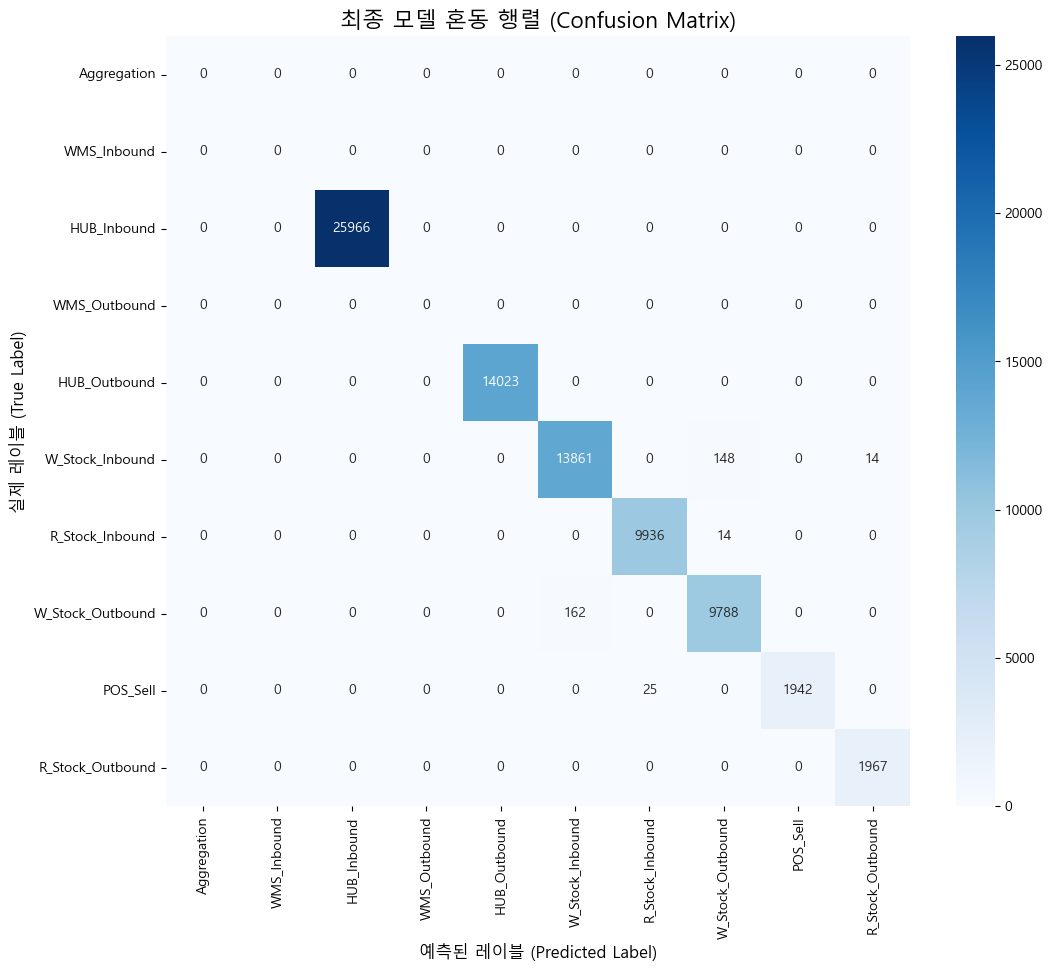

In [ ]:
# ===== (최종 셀) 단일 챔피언 모델(ws=3) 성능 평가 및 분석 =====
import numpy as np
import pandas as pd # 혼동 행렬 시각화를 위해 추가
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 최종 모델(ws=3)로 테스트 데이터에 대한 예측 수행 ---
print("[INFO] 최종 모델(ws=3)로 예측을 수행합니다...")
# ws=2 관련 코드는 모두 제거하고, ws=3 데이터만 사용합니다.
pred_prob_final = model_ws3_reg.predict(X_test_ws3)
pred_class_final = np.argmax(pred_prob_final, axis=1)


# --- 2. 최종 모델 성능 리포트 출력 ---
# classification_report를 위한 라벨 정보 준비
target_names = vocab_event['id2token'][2:]
labels_to_report = list(range(2, VOCAB_SIZE_EVENT))

print("\n\n--- 최종 모델 (ws=3, 규제됨) 성능 리포트 ---")
final_accuracy = accuracy_score(y_test_ws3, pred_class_final)
print(f"정확도 (Accuracy): {final_accuracy:.4f}")
print(classification_report(y_test_ws3, pred_class_final,
                            labels=labels_to_report,
                            target_names=target_names,
                            zero_division=0))

# --- 3. 성능 시각화: 혼동 행렬(Confusion Matrix) ---
# 혼동 행렬은 모델이 어떤 클래스를 어떤 클래스로 잘못 예측하는지 보여주는 강력한 도구입니다.
print("\n[INFO] 혼동 행렬(Confusion Matrix)을 생성합니다...")
cm = confusion_matrix(y_test_ws3, pred_class_final, labels=labels_to_report)

# 시각화를 위해 DataFrame으로 변환
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

# 히트맵(Heatmap)으로 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('최종 모델 혼동 행렬 (Confusion Matrix)', fontsize=16)
plt.xlabel('예측된 레이블 (Predicted Label)', fontsize=12)
plt.ylabel('실제 레이블 (True Label)', fontsize=12)
plt.show()